In [1]:
using Oceananigans
using Oceananigans.OutputWriters, Oceananigans.Fields
using Oceananigans.Utils:day, hour, minute, second
using Plots, JLD2, Printf, Oceananigans.Grids

In [10]:
gr()

Plots.GRBackend()

In [3]:
function fileremover(files)
    dir=readdir()
    for filename in files
        if (filename in dir)
            rm(filename)
        end
    end
end

fileremover (generic function with 1 method)

In [13]:
grid1 = RegularCartesianGrid(size=(80,80,80), x=(-0.5,0.5),y=(-0.5,0.5), z=(-0.15,0.15), topology = (Bounded, Bounded, Bounded))

@inline heater(x,y,t)=18.0*(cos(2x)+cos(2y))
@inline cooler(x,y,t)=9*(cos(4x)+cos(4y))

t_bcs = TracerBoundaryConditions(grid1, bottom = BoundaryCondition(Value,heater), top=BoundaryCondition(Value,cooler))

model1 = IncompressibleModel(grid=grid1, boundary_conditions=(T=t_bcs,),tracers=(:T,:S),closure=IsotropicDiffusivity(ν=2e-4, κ=5e-7),
                            timestepper= :RungeKutta3)

println(model1)
println(model1.velocities.u)
println(model1.tracers.T)

@inline randvel(x,y,z)=randn()
@inline randtemp(x,y,z)=18+5randn()
@inline randsal(x,y,z)=35+8randn()
set!(model1,T=randtemp,S=randsal,u=randvel,v=randvel,w=randvel)

wizard=TimeStepWizard(cfl=0.1, Δt=0.0001, max_Δt=0.1)

simulation = Simulation(model1, Δt=wizard, stop_time=50second, iteration_interval=2)

function init_save_some_metadata!(file, model)
    file["author"] = "oofs"
    return nothing
end

fileremover(["ConvectionVelocityData.jld2","ConvectionTempData.jld2"])

simulation.output_writers[:velocities] = JLD2OutputWriter(model1, model1.velocities,
                                                          prefix = "ConvectionVelocityData",
                                                          schedule = TimeInterval(0.25second),
                                                          init = init_save_some_metadata!)

simulation.output_writers[:tracers] = JLD2OutputWriter(model1, model1.tracers,
                                                          prefix = "ConvectionTempData",
                                                          schedule = TimeInterval(0.25second),
                                                          init = init_save_some_metadata!)



run!(simulation)

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=80, Ny=80, Nz=80)
├── tracers: (:T, :S)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:T, :S),Tuple{Float64,Float64}}}
├── buoyancy: SeawaterBuoyancy{Float64,LinearEquationOfState{Float64},Nothing,Nothing}
└── coriolis: Nothing
Field located at (Face, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (83, 82, 82)
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=80, Ny=80, Nz=80)
└── boundary conditions: x=(west=NormalFlow, east=NormalFlow), y=(south=ZeroFlux, north=ZeroFlux), z=(bottom=ZeroFlux, top=ZeroFlux)
Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (82, 82, 82)
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=80, Ny=80, Nz=80)
└── boundary conditions: x=(west=ZeroFlux, east=ZeroFlux), y=(south=ZeroFlux, n

┌ Info: Simulation is stopping. Model time 50.006 seconds has hit or exceeded simulation stop time 50 seconds.
└ @ Oceananigans.Simulations /Users/jerobinett/.julia/packages/Oceananigans/RxUYW/src/Simulations/run.jl:40


┌ Info: Saved animation to 
│   fn = /Users/jerobinett/Desktop/JuliaPractice/Convection W-Velocity.gif
└ @ Plots /Users/jerobinett/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/jerobinett/Desktop/JuliaPractice/Convection W-Velocity.gif")
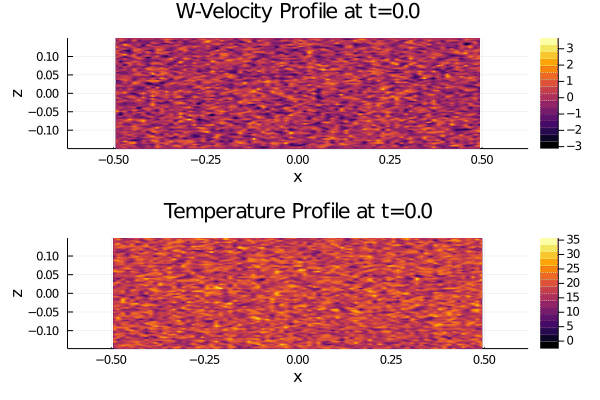

In [23]:
let
    xVel, yVel, zVel = nodes(model1.velocities.w)
    xT,yT,zT=nodes(model1.tracers.T)
    fileVel = jldopen(simulation.output_writers[:velocities].filepath)
    fileTracer=jldopen(simulation.output_writers[:tracers].filepath)
    iterations = parse.(Int, keys(fileVel["timeseries/t"]))
    anim = @animate for (i, iter) in enumerate(iterations)

        wvel = transpose(fileVel["timeseries/w/$iter"][:,fld(end,2),:])
        timeofthing=fileVel["timeseries/t/$iter"]

        wContours=contourf(xVel, zVel, wvel, title = "W-Velocity Profile at t=$timeofthing",linewidth=0,xlabel = "x",ylabel = "z")
        
        T = transpose(fileTracer["timeseries/T/$iter"][:,fld(end,2),:])

        TContours=contourf(xT,zT, T, title = "Temperature Profile at t=$timeofthing",linewidth=0,xlabel = "x",ylabel = "z")
        
        plot(wContours,TContours, layout = (2, 1), legend = false, aspect_ratio=:equal)
    end
    gif(anim, "Convection W-Velocity.gif", fps = 4)
end